# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**: Székely Szilárd Lehel

**Neptun code:** EKMIRA

**Date:** 09/01/2024 9AM-10AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-image Diffusion like model, and the forward function. The model receives an intial image and a text as input (describes how the final image should look like) and generates an image according to the two.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [15]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/11gey3SssCJe6CIUiFON9e-eoLdkegDna/view?usp=drive_link

<br>
<br>

![](https://drive.google.com/uc?export=view&id=11gey3SssCJe6CIUiFON9e-eoLdkegDna)

#### Input image

In [16]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [17]:
image.shape

(3, 256, 256)

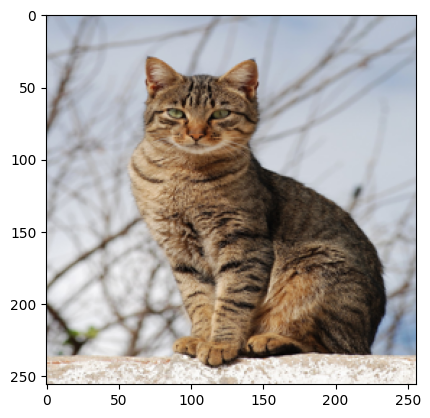

In [18]:
plt.imshow(np.moveaxis(image, 0,-1))

In [19]:
#Simple pre-processing
input_image = torch.tensor(image,dtype=torch.float32)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### Input text

In [20]:
text = "A cat wearing sunglasses and suit"

# Simple preprocessing the text
word_to_ix = {"A": 0, "cat": 1, "wearing": 2, "sunglasses": 3, "and": 4, "suit": 5}
lookup_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

vocab_size = len(lookup_tensor)

In [21]:
vocab_size

6

#### 1.1. Implement the architecture

In [22]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()

        # nn.Embedding layer will contain a matrix of shape [vocab_size, embedding_dim]
        # where each row corresponds to a word in the vocabulary.        
        self.emb = nn.Embedding(num_embeddings=6, embedding_dim=1024)

        # nn.ConvTranspose2d layer will apply a transposed 2D convolution.
        # It will transform the input volume with 6 channels to an output volume with 32 channels.
        # kernel_size=4, stride=4, padding=0 determine the spatial transformation of this operation.
        self.convt2d = nn.ConvTranspose2d(6, 32, kernel_size=4, stride=4, padding=0)

    def forward(self, input_text):
        # EMBED the input text'
        print('text encoder forward')

        # Forward pass of the text through the embedding layer. The input_text is a tensor
        # containing indices of words which are then mapped to their respective embeddings.
        # The output of this layer is a tensor of shape [batch_size, 6, 1024].
        x = self.emb(input_text)
        print(x.shape) # [1, 6, 1024]

        # The embeddings are reshaped to have dimensions [1, 6, 32, 32], which is necessary
        # for the next convolutional operation. This is a batch size of 1, with 6 channels,
        # and a spatial dimension of 32x32.
        x = x.view(1, 6, 32, 32)
        print(x.shape) # [1, 6, 32, 32]
        
        # The reshaped embeddings are passed through the transposed convolutional layer.
        # This operation upsamples the data spatially to larger dimensions.
        x = self.convt2d(x)
        print(x.shape)

        # RESHAPE the embeddings and SEND them to the next layer
        return x

class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        # DEFINE the layers

        # First convolutional layer expects `in_channels` number of channels in the input image
        # and produces a tensor with 64 channels. The kernel size of 3 and 'same' padding ensures
        # that the spatial dimensions of the output are the same as the input.
        self.conv2d1 = nn.Conv2d(3, 64, kernel_size=3, padding='same') # in:[1, 3, 256, 256]  out:[1, 64, 256, 256]

        # Second convolutional layer takes the 64-channel tensor from the previous layer and
        # applies another convolution. The stride of 2 reduces the spatial dimensions by half,
        # effectively downsampling the input.
        self.conv2d2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # in:[1, 64, 256, 256]  out:[1, 64, 128, 128]

        # Batch normalization layer normalizes the activations from the previous layer, which
        # can accelerate training and provide some regularization.
        self.batchnorm = nn.BatchNorm2d(64) # in:[1, 64, 128, 128]  out:[1, 64, 128, 128]

    def forward(self, input_image):
        # SEND the input image and then the features to the given layers
        print('image encoder forward')

        # Forward pass of the image through the first convolutional layer.
        x = self.conv2d1(input_image)
        print(x.shape)
        
        # Apply ReLU activation function to introduce non-linearity.
        x = nn.functional.relu(x)
        
        # Pass the activations through the second convolutional layer.
        x = self.conv2d2(x)
        print(x.shape)

        # Apply ReLU activation function again.
        x = nn.functional.relu(x)

        # Pass the activations through the batch normalization layer.
        x = self.batchnorm(x)
        print(x.shape)
        return x

class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        # DEFINE the layers

        # Batch normalization layer for the incoming features from the U-Net.
        self.batchnorm = nn.BatchNorm2d(64)

        # Transposed convolutional layer upsamples the 64-channel tensor back to a tensor
        # with 3 channels (assuming RGB image), with a kernel size of 2 and stride of 2,
        # effectively doubling the spatial dimensions.
        self.convt2d = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)

    def forward(self, image_features):
        # SEND the image features to the given layers
        x = self.batchnorm(image_features)
        x = self.convt2d(x)
        x = nn.functional.relu(x)
        return x

class MyUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyUNet, self).__init__()
        # DEFINE the layers

        self.conv2d1 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.conv2d2 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.conv2d3 = nn.Conv2d(256, 64, kernel_size=2, padding='same')
        self.conv2d4 = nn.Conv2d(256, 64, kernel_size=3, padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convt2d = nn.ConvTranspose2d(320, 128, kernel_size=4, stride=2, padding=1)


    def forward(self, combined_features):
        # SEND the combined features to the given layers of the downscaling part of the U-Net

        # COMBINE the features before you send them to the ConvTranspose2d layer of the U-Net

        # SEND the COMBINED features to the ConvTranspose2d layer

        # COMBINE the features again before you send them to the last Conv2d layer of the U-Net

        # SEND the COMBINED features to the last Conv2d and ReLU layer of the U-Net
        print('unet forward')
        x = self.conv2d1(combined_features)
        a = nn.functional.relu(x)
        b = self.maxpool1(a)
        b = self.conv2d2(b)
        b = nn.functional.relu(b)
        c = self.conv2d3(b)
        c = nn.functional.relu(c)
        print('b', b.shape)
        print('c', c.shape)
        b = torch.cat((b, c), 1)
        print('cat', b.shape)
        b = self.convt2d(b)
        print('b', b.shape)
        print('a', a.shape)
        a = torch.cat((a, b), 1)
        print('cat', a.shape)
        a = self.conv2d4(a)
        print('a', a.shape)
        x = nn.functional.relu(a)
        print(a.shape)
        return x

class ImageToImageGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels):
        super(ImageToImageGenerator, self).__init__()
        # DEFINE the TEXT ENCODER, IMAGE ENCODER, U-NET, and IMAGE DECODER
        self.text_encoder = TextEncoder(vocab_size, embedding_dim, text_encoder_out_channels)

        self.image_encoder = ImageEncoder(image_channels, image_encoder_out_channels)

        self.u_net = MyUNet(image_channels, unet_out_channels)

        self.image_decoder = ImageDecoder(image_channels, image_encoder_out_channels)

    def forward(self, input_text, input_image):
        # SEND the input text to the TEXT ENCODER
        text_encoder = self.text_encoder(input_text)
        print('text', text_encoder.shape)

        # SEND the input image to the IMAGE ENCODER
        image_encoder = self.image_encoder(input_image)
        print('image', image_encoder.shape)

        # COMBINE the TEXT FEATURES form the TEXT ENCODER and IMAGE FETURES from the IMAGE ENCODER
        concatenated = torch.cat((image_encoder, text_encoder), 1)
        print('concat', concatenated.shape)

        # SEND the COMBINED FETURES to the U-NET
        u_net = self.u_net(concatenated)
        print('unet', u_net.shape)

        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER
        generated_image = self.image_decoder(u_net)
        print(generated_image.shape)

        return generated_image

#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

In [23]:
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64
model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels)

input_text = lookup_tensor

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)

text encoder forward
torch.Size([6, 1024])
torch.Size([1, 6, 32, 32])
torch.Size([1, 32, 128, 128])
text torch.Size([1, 32, 128, 128])
image encoder forward
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
image torch.Size([1, 64, 128, 128])
concat torch.Size([1, 96, 128, 128])
unet forward
b torch.Size([1, 256, 64, 64])
c torch.Size([1, 64, 64, 64])
cat torch.Size([1, 320, 64, 64])
b torch.Size([1, 128, 128, 128])
a torch.Size([1, 128, 128, 128])
cat torch.Size([1, 256, 128, 128])
a torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
unet torch.Size([1, 64, 128, 128])
torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
Output Image Shape: torch.Size([1, 3, 256, 256])


For fun -- check the generated image, it should look something like this: https://drive.google.com/file/d/1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA)


In [24]:
model

ImageToImageGenerator(
  (text_encoder): TextEncoder(
    (emb): Embedding(6, 1024)
    (convt2d): ConvTranspose2d(6, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (image_encoder): ImageEncoder(
    (conv2d1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (u_net): MyUNet(
    (conv2d1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d3): Conv2d(256, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (conv2d4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convt2d): ConvTranspose2d(320, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (image_decoder): 

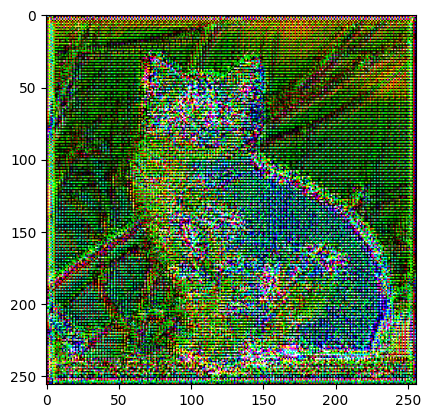

In [25]:
%matplotlib inline

rgb_array = output[0].permute(1, 2, 0).detach().numpy()
rgb_array = rgb_array.clip(0, 1)
plt.imshow(rgb_array)

In [26]:
import torch.onnx

torch.onnx.export(model, (input_text, input_image), "model.onnx", verbose=True)

text encoder forward
torch.Size([6, 1024])
torch.Size([1, 6, 32, 32])
torch.Size([1, 32, 128, 128])
text torch.Size([1, 32, 128, 128])
image encoder forward
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
image torch.Size([1, 64, 128, 128])
concat torch.Size([1, 96, 128, 128])
unet forward
b torch.Size([1, 256, 64, 64])
c torch.Size([1, 64, 64, 64])
cat torch.Size([1, 320, 64, 64])
b torch.Size([1, 128, 128, 128])
a torch.Size([1, 128, 128, 128])
cat torch.Size([1, 256, 128, 128])
a torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
unet torch.Size([1, 64, 128, 128])
torch.Size([1, 3, 256, 256])
Exported graph: graph(%input.1 : Long(6, strides=[1], requires_grad=0, device=cpu),
      %input.3 : Float(1, 3, 256, 256, strides=[3, 1, 768, 3], requires_grad=0, device=cpu),
      %text_encoder.emb.weight : Float(6, 1024, strides=[1024, 1], requires_grad=1, device=cpu),
      %text_encoder.convt2d.weight : Float(6, 32, 4, 4, strides=[512, 16